# Image line reconstruction with U-Net architecture

## Download the data

The dataset consists in Da Vinci drawings reconsurction, that can be find [here](https://esslab.jp/~ess/en/data/davincidataset/) with the aim to reproduce the paper *Learning to Restore Deteriorated Line Drawing*

## Prepare paths of input images and target

The dataset was donwloaded and later, uploaded to colla temportal files. The dataset containts 71 images and their correspondent annotations.

In [2]:
import os

input_dir = "/content/images_re/"
target_dir = "/content/annotations_re/"
img_size = (256, 256)
batch_size = 10

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)

target_img_paths= []

for r in input_img_paths:
  
  aux = (r.replace(".png","_gt.png"))

  target_img_paths.append(aux.replace("images","annotations")) 


print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 71
/content/images_re/da10.png | /content/annotations_re/da10_gt.png
/content/images_re/da11.png | /content/annotations_re/da11_gt.png
/content/images_re/da12.png | /content/annotations_re/da12_gt.png
/content/images_re/da13.png | /content/annotations_re/da13_gt.png
/content/images_re/da14.png | /content/annotations_re/da14_gt.png
/content/images_re/da15.png | /content/annotations_re/da15_gt.png
/content/images_re/da16.png | /content/annotations_re/da16_gt.png
/content/images_re/da17.png | /content/annotations_re/da17_gt.png
/content/images_re/da18.png | /content/annotations_re/da18_gt.png
/content/images_re/da19.png | /content/annotations_re/da19_gt.png


In [ ]:
# RUN

#Desired target size 
size = 256
# Input path
trainPath = r"/content/annotations/"
#Output path to tore the resized images
train_resized_path = r"/content/annotations_re/"

# (1)List of images in the directory
train_imgName = getFilaName(trainPath)

# (2)Resize images and save them

for i in range(len(train_imgName)):
    
    path = join(trainPath,train_imgName[i])
    
    new_im = resize(size,path)

    new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY) # ative when annotations

    path_resize = join(train_resized_path, train_imgName[i].replace('.png','.png'))
    
    cv2.imwrite(path_resize, new_im)

## Show the input image and their correspondent target:

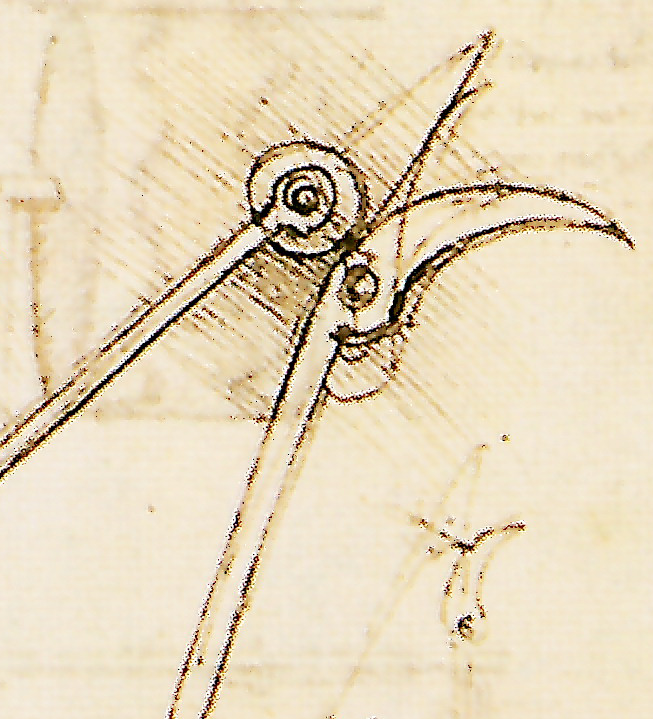

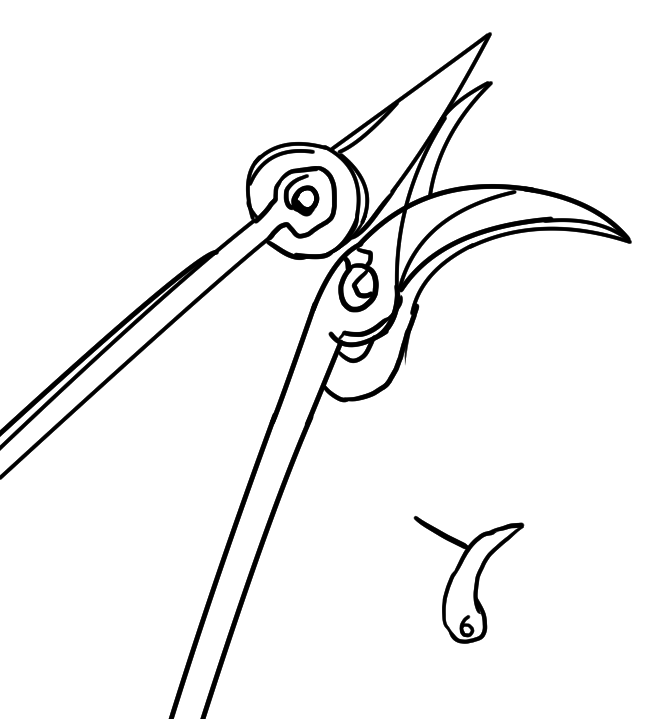

In [4]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[1]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[1]))
display(img)

## Prepare dataset into batches and fit them into tensors

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class imageToTensor(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        #Returns tuple (input, target) correspond to batch #idx.
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            
        return x, y


## Define U-net model

In [6]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

def Unet(input_size):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)
  
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3) # Donwsampling - upsampling connection characterisc of U-net
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  
  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3) # Donwsampling - upsampling connection characterisc of U-net
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  
  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3) # Donwsampling - upsampling connection characterisc of U-net
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3) # Donwsampling - upsampling connection characterisc of U-net
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  output = Conv2D(1, 1, activation = 'sigmoid')(conv9)
  
  model = Model(inputs, output)
  
  model.summary()
  
  return model
    
# Build the model
model = Unet(input_size = (256,256,3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Define Training and validation tensors before train

Taking into consideration, there are only 71 images and data-augmentation was not use it, the validation samples were defined as 11. 

In [7]:
import random

# Split our img paths into a training and a validation set
val_samples = 11

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split:
train_gen = imageToTensor(batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = imageToTensor(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

It could be seen, there is no convergene during training. This could be due to dataset size, or problem inside the class ``` imageToTensor``` definition. 


In [12]:
# Define the hyperparameters before training
from keras.optimizers import *

model.compile(optimizer=Adam(lr = 1e-4), loss="binary_crossentropy") # Loss for white or black pixel definition to achieve the target

# Train the model, doing validation at the end of each epoch.
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/5
6/6 [==============================] - 12s 2s/step - loss: nan - val_loss: nan
Epoch 2/5
6/6 [==============================] - 10s 2s/step - loss: nan - val_loss: nan
Epoch 3/5
6/6 [==============================] - 10s 2s/step - loss: nan - val_loss: nan
Epoch 4/5
6/6 [==============================] - 10s 2s/step - loss: nan - val_loss: nan
Epoch 5/5
6/6 [==============================] - 10s 2s/step - loss: nan - val_loss: nan


## Visualize predictions

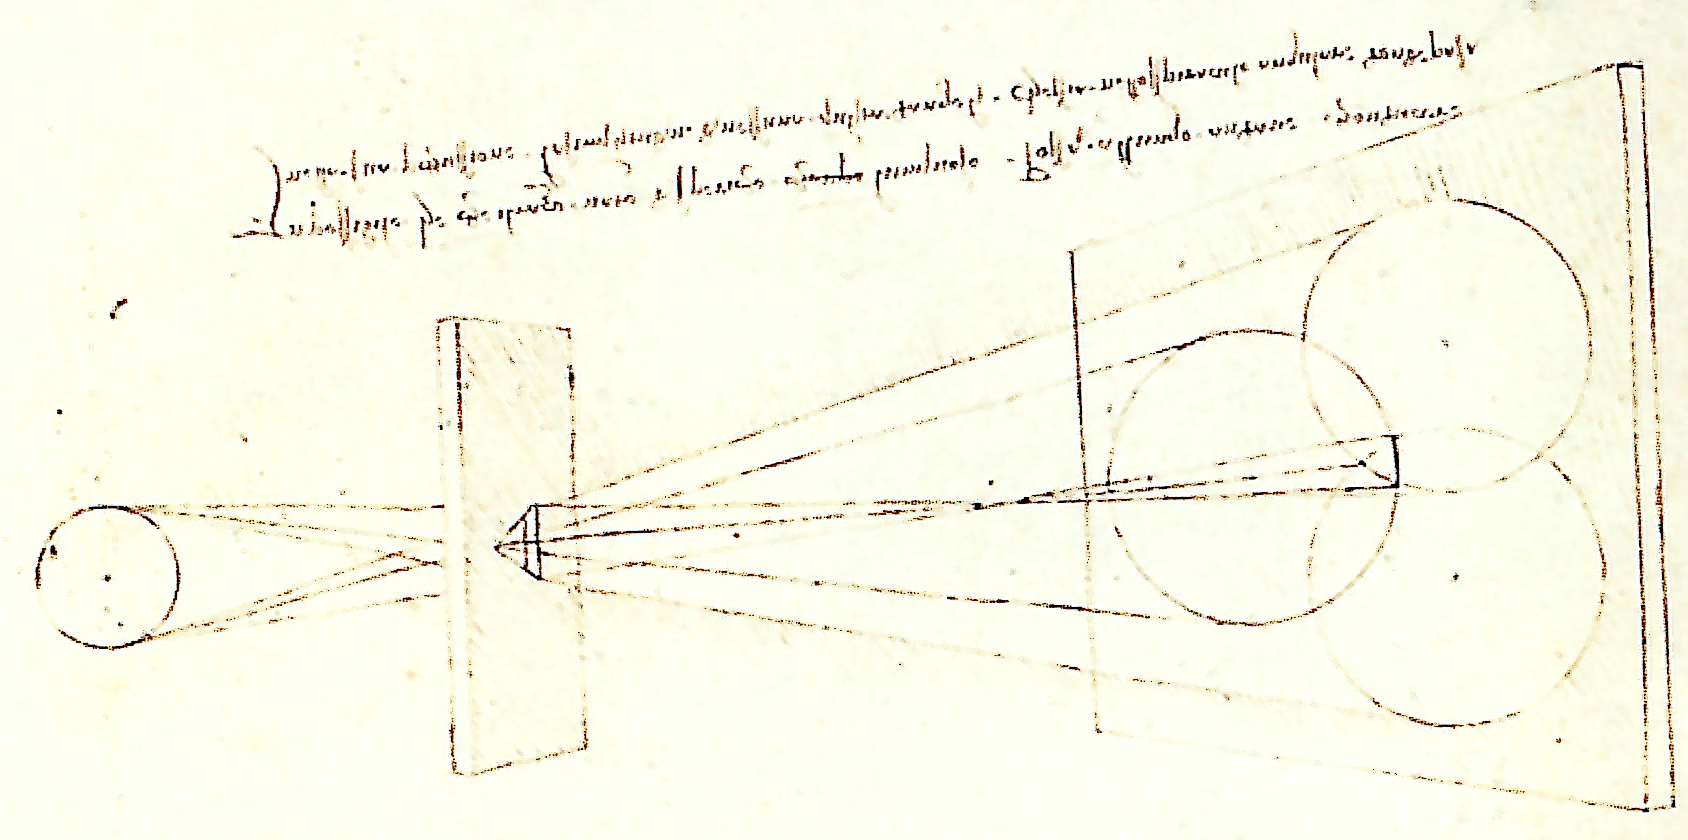

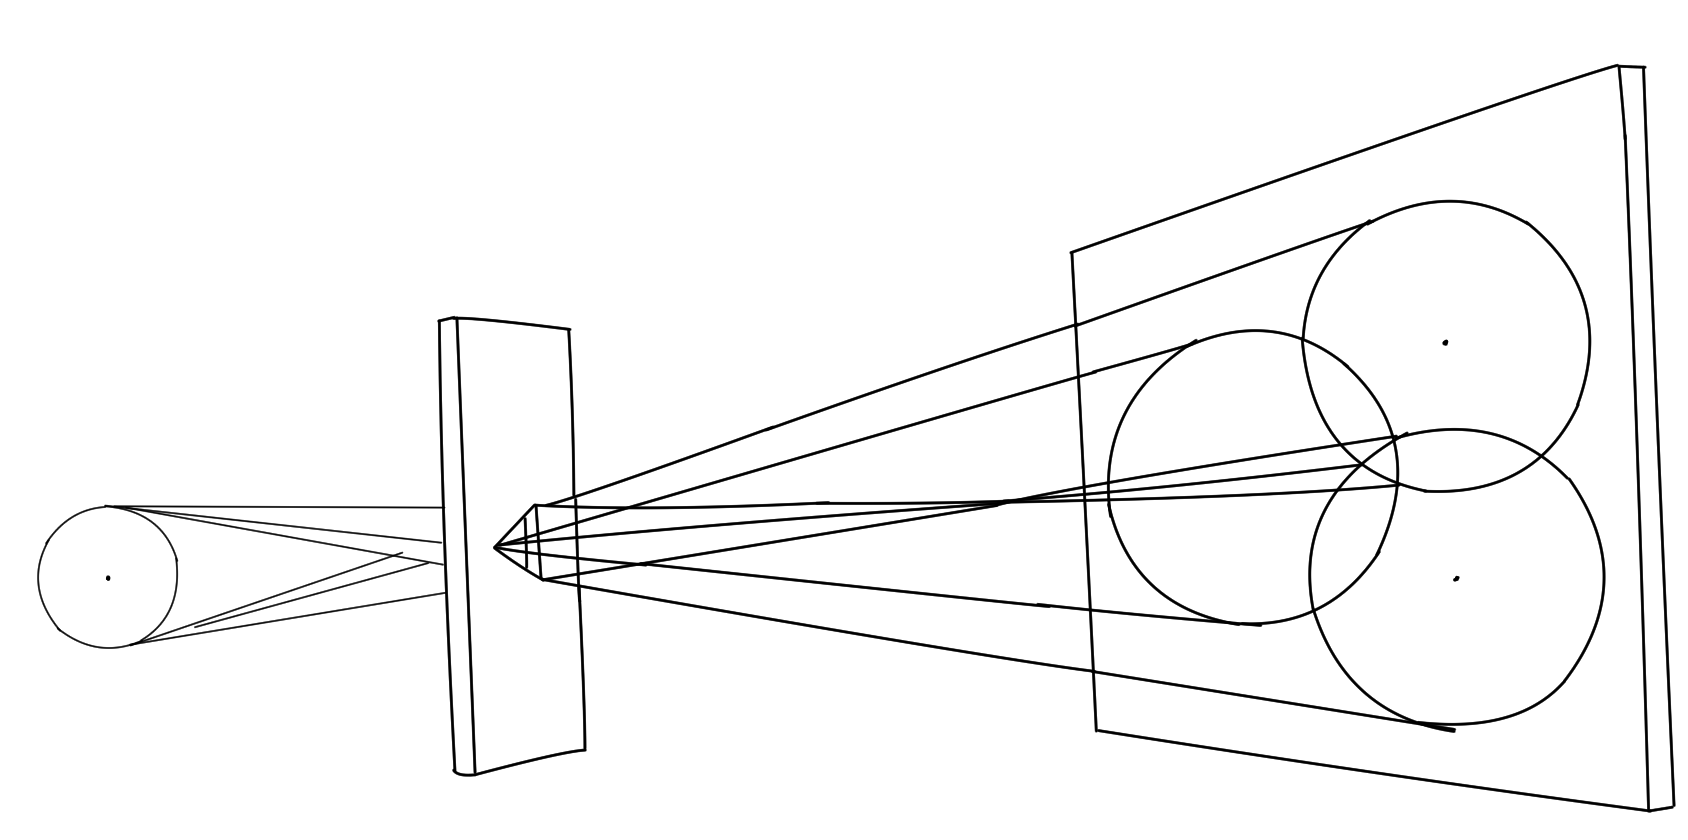

AttributeError: ignored

In [13]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Generate predictions the images in the validation set

val_gen = imageToTensor(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image:
i = 3

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target 
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display predicted reconstructed image


img_pred = np.argmax(val_preds[i], axis=-1)
img_pred = np.expand_dims(img_pred, axis=-1)
img_pred = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(img_pred))
display(img_pred)